In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt


Bad key savefig.frameon in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = cad_jpy_df.Price.pct_change()*100
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return'] = cad_jpy_df['Return'].shift()
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.tail()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), 
X_train = train['Lagged_Return'].to_frame()
# X_test (test set of of just the independent variables)
X_test = test['Lagged_Return'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), 
Y_train = train['Return']
# Y_test (test set of just the "y" variable):
Y_test = test['Return']

In [8]:
# Preview the X_train data
X_train

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
...,...
2017-12-25,-0.011240
2017-12-26,0.033723
2017-12-27,0.269693


In [9]:
# The training data has 7293 data points which is 92% of the data. The remaining data is set for testing.

<AxesSubplot:xlabel='Date'>

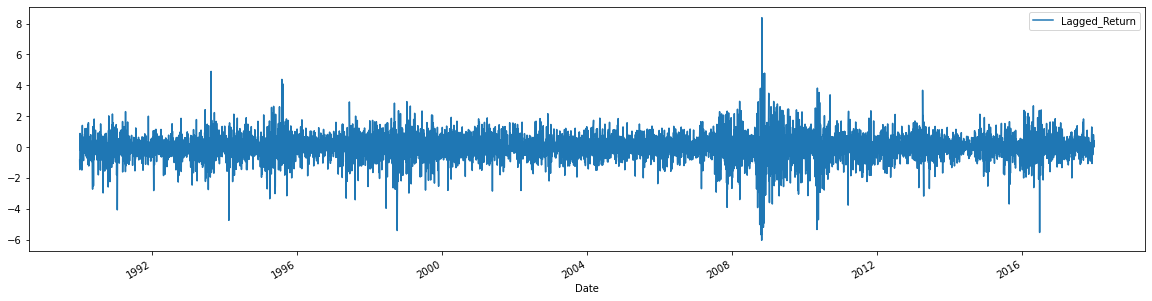

In [10]:
X_train.plot(figsize=(20,5))

# Linear Regression Model

In [11]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [12]:
# Make a prediction of "y" values using just the test dataset
predicted_y_values = model.predict(X_test)

In [13]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = Y_test.to_frame()
results['Predicted Return'] = predicted_y_values
results.head()

,Return,Predicted Return
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366


<AxesSubplot:xlabel='Date', ylabel='Price'>

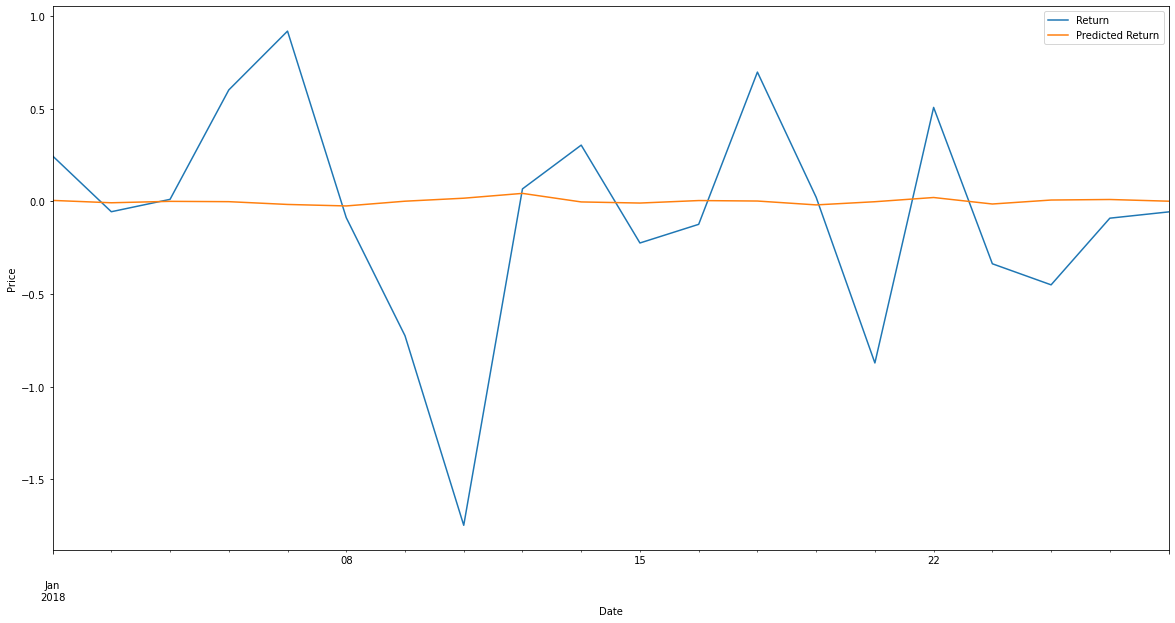

In [14]:
# Plot the first 20 predictions vs the true values
results[:20].plot(figsize=(20,10), ylabel="Price")

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [15]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
MSE = mean_squared_error(results['Return'],results['Predicted Return'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
RMSE = np.sqrt(MSE**2/len(results))

In [16]:
print(f'The Mean Square Error is {MSE}')
print(f'The Root-Mean squared error is {RMSE}')

The Mean Square Error is 0.415484105880405
The Root-Mean squared error is 0.016500981819524085


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [21]:
# Construct a dataframe using just the "y" training data:
in_sample_results = Y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  

in_sample_results['In-sample Predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
In_MSE = mean_squared_error(in_sample_results['Return'],in_sample_results['In-sample Predictions'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
RMSE = np.sqrt(In_MSE**2/len(in_sample_results))

print(f'The in-sample Mean Square Error is {MSE}')
print(f'The in-sample Root-Mean squared error is {RMSE}')

The in-sample Mean Square Error is 0.415484105880405
The in-sample Root-Mean squared error is 0.00830167141225435


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** The lower the MSE and RMSE, the better when determining if a model can accurately predict data. The MSE for the out of sample data and in-sample data appear to be the exact same. The RMSE however is lower for the in-sample performance data. Therefore the model performs slightly better in-sample data. However, the difference is so small that it could be seen that the model performs equally as well in both in sample and out of sample data scenarios.